# Stacking and Blending (Assignment 4)

## Student: Rodolfo Lerma

In this lab assignment, you will build a non-tree-based classifier where you can ensemble any base-learners and pass it to the using a BaggingClassifier or any of the other ensemble learners in sklearn.ensemble.

In [1]:
# import packages
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import pandas as pd
from sklearn.datasets import make_moons
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample

# make this notebook's output stable across runs
np.random.seed(0)

## Data Set Information:

This dataset represents a set of possible advertisements on Internet pages. The features encode the geometry of the image (if available) as well as phrases occuring in the URL, the image's URL and alt text, the anchor text, and words occuring near the anchor text. The task is to predict whether an image is an advertisement ("ad") or not ("nonad"). Additional information can be found [here](https://archive.ics.uci.edu/ml/datasets/internet%2Badvertisements).

## Attribute Information:

The dataset has 3 continous (height, width, aratio) and 1555 binary (urls, tags, captions) features. 

## Source:

Creator & donor: Nicholas Kushmerick <nick '@' ucd.ie>

In [2]:
# Load the data
internetAd = pd.read_csv('Internet_Ad_Data.csv', sep=',', error_bad_lines=False)

C:\Users\ly266e\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
print(internetAd.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3279 entries, 0 to 3278
Columns: 1559 entries, height to Target
dtypes: int64(1554), object(5)
memory usage: 39.0+ MB
None


In [4]:
internetAd.head(20)

,height,width,aratio,local,url*images+buttons,url*likesbooks.com,url*www.slake.com,url*hydrogeologist,url*oso,url*media,...,caption*home,caption*my,caption*your,caption*in,caption*bytes,caption*here,caption*click,caption*for,caption*you,Target
0,125,125,1.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
1,57,468,8.2105,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
2,33,230,6.9696,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
3,60,468,7.8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
4,60,468,7.8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
5,60,468,7.8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
6,59,460,7.7966,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
7,60,234,3.9,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
8,60,468,7.8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
9,60,468,7.8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.


In [5]:
internetAd.shape

(3279, 1559)

It is possible to notice the high number of features in the dataset (curse of dimensionality).

## Question 1: Prepare and impute missing values with the median

In [6]:
options = ["?"," ?" ," ? ","   ?", "     ?", "      ?","       ?","     ?  ","     ?   "]
for i in options:
    internetAd.replace(i, np.nan, inplace=True)

In [7]:
#Convert values to numeric
sample_columns = ['height', 'width', 'aratio', 'local']
for i in sample_columns:
    internetAd[i] = pd.to_numeric(internetAd[i]) 

In [8]:
internetAd.dtypes

height                       float64
width                        float64
aratio                       float64
local                        float64
url*images+buttons             int64
url*likesbooks.com             int64
url*www.slake.com              int64
url*hydrogeologist             int64
url*oso                        int64
url*media                      int64
url*peace+images               int64
url*blipverts                  int64
url*tkaine+kats                int64
url*labyrinth                  int64
url*advertising+blipverts      int64
url*images+oso                 int64
url*area51+corridor            int64
url*ran+gifs                   int64
url*express-scripts.com        int64
url*off                        int64
url*cnet                       int64
url*time+1998                  int64
url*josefina3                  int64
url*truluck.com                int64
url*clawnext+gif               int64
url*autopen.com                int64
url*tvgen.com                  int64
u

In [9]:
#Replacing ad. and nonad.
internetAd.replace(to_replace = ['ad.','nonad.'], value = [1,0], inplace = True)

In [10]:
internetAd['height'].isnull().sum()

903

We have 903 missing values just in the `height` column.

In [11]:
column_names = internetAd.columns.tolist()
columns_with_null = []
for i in column_names:
    x = internetAd[i].isnull().sum()
    if x > 0:
        columns_with_null.append(i)
    else:
        pass        

In [12]:
columns_with_null

['height', 'width', 'aratio', 'local']

There are 4 columns with missing values as seen above.

In [13]:
for i in columns_with_null:
    internetAd[i].fillna(internetAd[i].median(), inplace=True)

In [14]:
#Check to verify transformations
internetAd.head(15)

,height,width,aratio,local,url*images+buttons,url*likesbooks.com,url*www.slake.com,url*hydrogeologist,url*oso,url*media,...,caption*home,caption*my,caption*your,caption*in,caption*bytes,caption*here,caption*click,caption*for,caption*you,Target
0,125.0,125.0,1.0000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,57.0,468.0,8.2105,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,33.0,230.0,6.9696,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,60.0,468.0,7.8000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,60.0,468.0,7.8000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,60.0,468.0,7.8000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,59.0,460.0,7.7966,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7,60.0,234.0,3.9000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8,60.0,468.0,7.8000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9,60.0,468.0,7.8000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


As we can notice all missing values (`?`) have been imputed by the median of that particular feature.

### Exploration of dataset

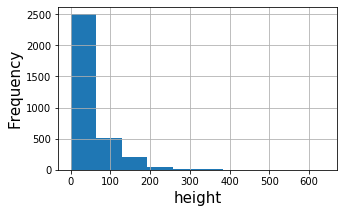

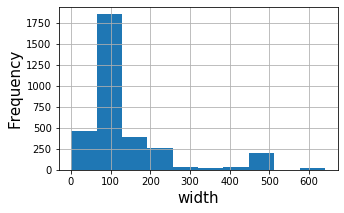

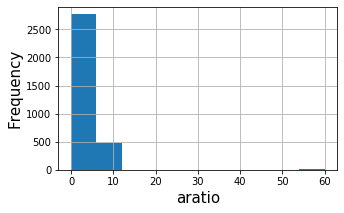

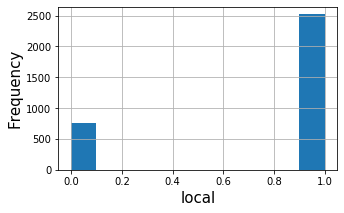

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def hist_plot(df,a):
    df[a].hist(figsize = (5,3))
    plt.xlabel(a, fontsize = 15)
    plt.ylabel('Frequency',fontsize = 15)
    plt.tick_params(axis="x", labelsize=10)
    plt.tick_params(axis="y", labelsize=10)
    plt.grid(True)
    plt.show()

for i in sample_columns:
    hist_plot(internetAd, i)

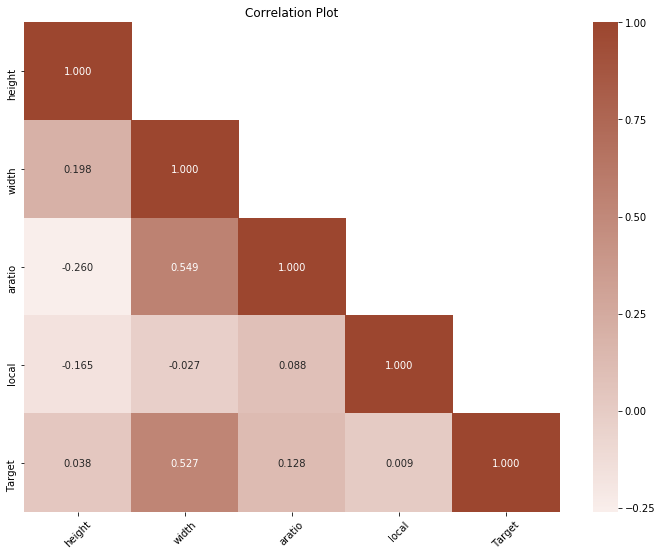

In [16]:
import seaborn as sns

comparison = ['height', 'width', 'aratio', 'local', 'Target']
corr = internetAd[comparison].corr()
hm_fig, hm_ax = plt.subplots(figsize=(12,9))
mask = np.logical_not(np.tril(np.ones_like(corr, dtype=np.bool)))
sns.heatmap(
    corr,
    annot=True,
    mask=mask,
    fmt='.3f',
    ax=hm_ax,
    cmap=sns.light_palette('#9c462f', n_colors=300),
)
hm_ax.set_xticklabels(hm_ax.get_xticklabels(), rotation=45)
hm_ax.set_title('Correlation Plot')
hm_ax.patch.set_alpha(0);

### Target Variable

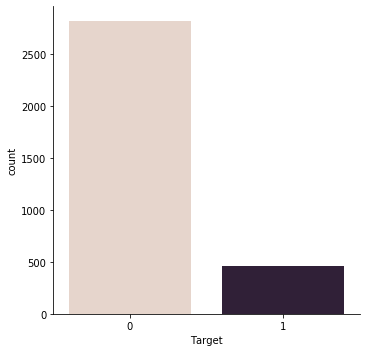

In [17]:
import seaborn as sns
sns.catplot(x="Target", kind="count", palette="ch:.1", data=internetAd)

Here it is important to notice the class imbalance situation.

## Question 2: Split dataset into training and test set

As it is possible to notice there is a wide variation across the different features. Therefore I will normalize the features using MinMaxScalar method.

Also the dataset will be split into training and testing. The testing portion will not be touch but until the final model is decided/selected.

In [18]:
from sklearn.model_selection import train_test_split

columns_no_target = internetAd.columns.to_list()
columns_no_target.remove('Target')

X = internetAd[columns_no_target]
y = internetAd['Target']

X_train_original, X_test_final, y_train_original, y_test_final = train_test_split(X, y, test_size=0.2, random_state=42)

In [58]:
#Minmax normalization
scalerfinal = MinMaxScaler()
scalerfinal.fit(X_test_final)

X_test_final = scalerfinal.transform(X_test_final)

### A further split is used to obtain the `train` & `validation` set.

#### Class Imbalance

This also could have been done in the model itself, but as a way to standarize how this is applied it was decided to do it here.

In [19]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
variables_res, label_res = sm.fit_resample(X_train_original, y_train_original)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(variables_res, label_res, test_size=0.2, random_state=42)

In [21]:
from sklearn.preprocessing import MinMaxScaler

#Minmax normalization
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_minmax_scaled = scaler.transform(X_train)
X_test_minmax_scaled = scaler.transform(X_test)

## Question 3: Train and evaluate a LogisticRegression classifier using LogisticRegression.Use Gridsearch CV to determine the best k.

In [22]:
max_iter_options = [1000,10000]
penalty_options = ['l1', 'l2', 'elasticnet', 'none']
solver_options = ['saga']
multi = ['multinomial']

parameters = {'penalty': penalty_options,
           'solver': solver_options,
           'multi_class': multi,
           'max_iter': max_iter_options}

lr_base = LogisticRegression()

lr_grid = GridSearchCV(estimator = lr_base, param_grid = parameters,
                        cv = 10, verbose = 2, n_jobs = -1)

lr_grid.fit(X_train_minmax_scaled, y_train)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


C:\Users\ly266e\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [0.90889508 0.93276682        nan 0.93331326 0.90889508 0.93276682
        nan 0.93166717]
  category=UserWarning
C:\Users\ly266e\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


GridSearchCV(cv=10, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'max_iter': [1000, 10000],
                         'multi_class': ['multinomial'],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['saga']},
             verbose=2)

In [23]:
x = lr_grid.best_params_
x

{'max_iter': 1000,
 'multi_class': 'multinomial',
 'penalty': 'none',
 'solver': 'saga'}

In [24]:
# make predictions with the trained random forest
test_x = lr_grid.predict(X_test_minmax_scaled)
test_x_prob = lr_grid.predict_proba(X_test_minmax_scaled)

In [25]:
def performance_values(X_test, y_test, trained_model):
    
    #Libraries
    from sklearn import preprocessing, metrics
    from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
    
    y_pred = trained_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    probs = trained_model.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.roc_auc_score(y_test, preds)
    
    return (fpr, tpr, accuracy, roc_auc)

In [26]:
def ROC_curve(fpr,tpr,roc_auc):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [27]:
fpr, tpr, lr_acc, lr_roc_auc = performance_values(X_test_minmax_scaled, y_test, lr_grid)
print("Accuracy: {}".format(lr_acc))
print("AUC: {}".format(lr_roc_auc))

Accuracy: 0.944078947368421
AUC: 0.9873797931351889


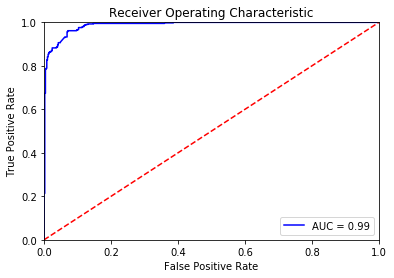

In [28]:
ROC_curve(fpr,tpr,lr_roc_auc)

## Question 4: Use BaggingClassifier to train and evaluate an ensemble model of LogisticRegression  base classifiers. Each base classifier should be trained only on a sample half the size of the training data, and using only half as many features as there are in in total the training data (read the documentation for the function to see how to do this). [Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html)

In [30]:
bagOkNN = BaggingClassifier(base_estimator = LogisticRegression(),
                            n_estimators = 20, max_samples = 0.50,
                            max_features = 0.50, random_state = 0)

bagOkNN.fit(X_train_minmax_scaled, y_train)

BaggingClassifier(base_estimator=LogisticRegression(), max_features=0.5,
                  max_samples=0.5, n_estimators=15, random_state=0)

In [31]:
# make predictions with the trained random forest
test_y = bagOkNN.predict(X_test_minmax_scaled)
test_y_prob = bagOkNN.predict_proba(X_test_minmax_scaled)

In [32]:
fpr, tpr, bag_acc, bag_roc_auc = performance_values(X_test_minmax_scaled, y_test, bagOkNN)
print("Accuracy: {}".format(bag_acc))
print("AUC: {}".format(bag_roc_auc))

Accuracy: 0.9407894736842105
AUC: 0.9871981202916454


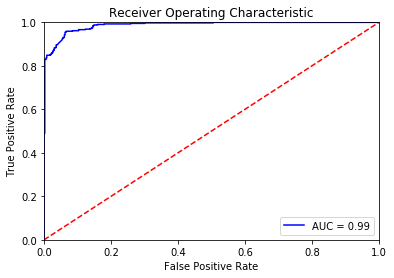

In [33]:
ROC_curve(fpr,tpr,bag_roc_auc)

## Question 5: Use AdaBoostClassifier to train and evaluate an ensemble model of LogisticRegression base classifiers. [Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)

In [35]:
boostOkNN = AdaBoostClassifier(base_estimator = LogisticRegression(),
                            n_estimators = 20, random_state = 0)

boostOkNN.fit(X_train_minmax_scaled, y_train)

AdaBoostClassifier(base_estimator=LogisticRegression(), n_estimators=20,
                   random_state=0)

In [36]:
# make predictions with the trained random forest
test_z = boostOkNN.predict(X_test_minmax_scaled)
test_z_prob = boostOkNN.predict_proba(X_test_minmax_scaled)

In [37]:
fpr, tpr, boost_acc, boost_roc_auc = performance_values(X_test_minmax_scaled, y_test, boostOkNN)
print("Accuracy: {}".format(boost_acc))
print("AUC: {}".format(boost_roc_auc))

Accuracy: 0.9024122807017544
AUC: 0.9544291839255867


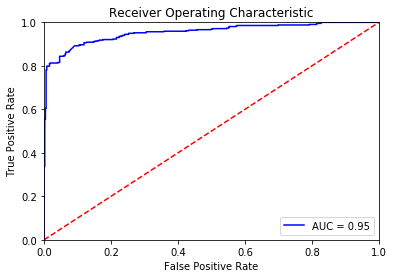

In [38]:
ROC_curve(fpr,tpr,boost_roc_auc)

## [Bonus] Question 6: Use StackingClassifier to train and evaluate an ensemble model of LogisticRegression base classifiers to get better accuracy than previous classifiers. [Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html)

In [42]:
from sklearn.ensemble import StackingClassifier

estimators = [('lr', LogisticRegression())]
stackingModel = StackingClassifier(estimators=estimators, cv = 10)
stackingModel.fit(X_train_minmax_scaled, y_train)

In [55]:
#make predictions with the trained random forest
test_w = stackingModel.predict(X_test_minmax_scaled)
test_w_prob = stackingModel.predict_proba(X_test_minmax_scaled)

In [56]:
fpr, tpr, stacking_acc, stacking_roc_auc = performance_values(X_test_minmax_scaled, y_test, stackingModel)
print("Accuracy: {}".format(stacking_acc))
print("AUC: {}".format(stacking_roc_auc))

Accuracy: 0.9418859649122807
AUC: 0.9877794733909844


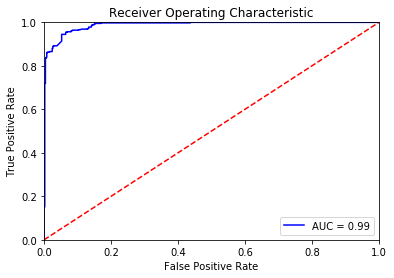

In [57]:
ROC_curve(fpr,tpr,stacking_roc_auc)

## Performance on unseen data.

### Logistic Regression

In [59]:
fpr, tpr, lr_acc_final, lr_roc_auc_final = performance_values(X_test_final, y_test_final, lr_grid)
print("Accuracy: {}".format(lr_acc_final))
print("AUC: {}".format(lr_roc_auc_final))

Accuracy: 0.9161585365853658
AUC: 0.9676636240046611


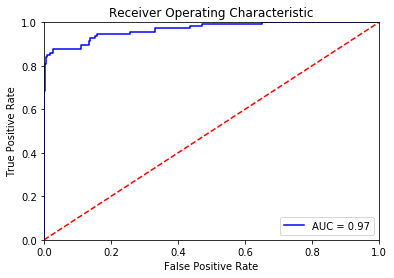

In [60]:
ROC_curve(fpr,tpr,lr_roc_auc_final)

### BaggingClassifier

In [61]:
fpr, tpr, bagging_acc_final, bagging_roc_auc_final = performance_values(X_test_final, y_test_final, bagOkNN)
print("Accuracy: {}".format(bagging_acc_final))
print("AUC: {}".format(bagging_roc_auc_final))

Accuracy: 0.9253048780487805
AUC: 0.9761118663818218


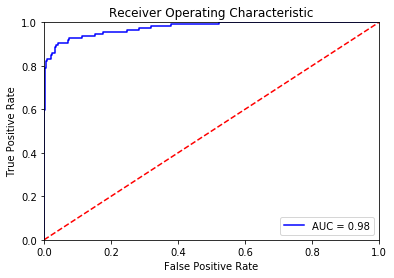

In [62]:
ROC_curve(fpr,tpr,bagging_roc_auc_final)

### AdaBoostClassifier

In [63]:
fpr, tpr, boost_acc_final, boost_roc_auc_final = performance_values(X_test_final, y_test_final, boostOkNN)
print("Accuracy: {}".format(boost_acc_final))
print("AUC: {}".format(boost_roc_auc_final))

Accuracy: 0.9527439024390244
AUC: 0.9617401437172266


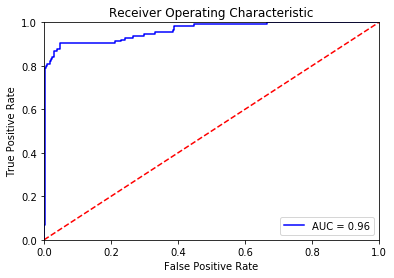

In [64]:
ROC_curve(fpr,tpr,boost_roc_auc_final)

### StackingClassifier

In [65]:
fpr, tpr, stacking_acc_final, stacking_roc_auc_final = performance_values(X_test_final, y_test_final, stackingModel)
print("Accuracy: {}".format(stacking_acc_final))
print("AUC: {}".format(stacking_roc_auc_final))

Accuracy: 0.9298780487804879
AUC: 0.9767430569042532


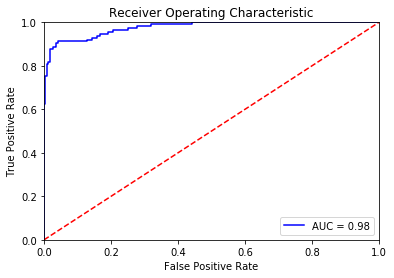

In [66]:
ROC_curve(fpr,tpr,stacking_roc_auc_final)

## Question 7: Create a new text cell in your Notebook: Complete a 50-100 word summary (or short description of your thinking in applying this week's learning to the solution) of your experience in this assignment. Include: 

- What was your incoming experience with this model, if any? 
- What steps you took, what obstacles you encountered? 
- How you link this exercise to real-world, machine learning problem-solving?
- What steps were missing? What else do you need to learn?